In [1]:
# Setup
import re
import os
import json
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

from utils import get_file_names

# Game of 24

In [2]:
#-----------------#
#---ToT Results---#
#-----------------#

def get_tot_results(file_name):
    with open(file_name, 'r') as file:
            run = json.load(file)

    # Compute cost
    cost = run[-1]["usage_so_far"]["cost"]

    # Compute accuracy
    rewards = []
    for puzzle in run:
        rewards.append({"r":1} in puzzle["infos"])
    
    return rewards, cost
    
    
folder = "arxiv/benchmarks/gameof24/ChatGPT/ToT/"
files = [folder + f for f in get_file_names(folder)]
rewards = []
costs = []

for file in files:
    rewards_, cost_ = get_tot_results(file)
    rewards.extend(rewards_)
    costs.append(cost_)

rewards = np.array(rewards)
costs = np.array(costs)

tot = {}    
tot["Accuracy"] = bootstrap(rewards.reshape((1,-1)), np.mean).bootstrap_distribution.mean()
tot["CI_Low"], tot["CI_High"] = bootstrap(rewards.reshape((1,-1)), np.mean).confidence_interval
tot["Cost"] = bootstrap(costs.reshape((1,-1)), np.mean).bootstrap_distribution.mean()

print(f"Game of 24 ToT results")
for key, value in tot.items():
    print(f"\t{key}: {value:.3f}")


Game of 24 ToT results
	Accuracy: 0.136
	CI_Low: 0.108
	CI_High: 0.168
	Cost: 1.711


In [3]:
#-----------------#
#---FoA Results---#
#-----------------#

def get_foa_data(file):
    with open(file, 'r') as f:
        run = json.load(f)
    
    
    data = {}
    params = file.split("/")[-1].split("_")
    data["num_agents"] = int(params[1].split("agents")[0])
    data["num_steps"] = int(params[2].split("steps")[0])
    data["k"] = int(params[3].split("k")[0])
    data["backtrack"] = float(params[5].split("backtrack")[0])

    data["Cost"] = run.pop("Cost")["total_cost"]

    rewards = []
    for puzzle in run.values():
        rewards.append(int({"r":1} in puzzle["Verifications"]))
    data["rewards"] = rewards
    data["Accuracy"] = np.mean(rewards)
    return data

folder = "logs_old/test/gameof24/"
files = [folder + f for f in get_file_names(folder)]

data = [get_foa_data(file) for file in files]

In [4]:
def plot_acc_cost(xs, y1, y2, variable, task):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

    ax1.plot(xs, y1, color="b", alpha=0.4, label="FoA")
    ax1.axhline(y=tot["Accuracy"], color='b', linestyle="--",label="ToT")
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Cost')
    ax1.set_title(f'Accuracy vs. {variable}')
    ax1.legend()

    ax2.plot(xs, y2, color="r", alpha=0.4, label="FoA")
    ax2.axhline(y=tot["Cost"], color='r', linestyle="--", label="ToT")
    ax2.set_xlabel(variable)
    ax2.set_ylabel('Cost')
    ax2.set_title(f'Cost vs. {variable}')
    ax2.legend()

    # Show the plot
    plt.suptitle(f"{task.capitalize()}")
    plt.savefig(f"pics/hyperparameter_search/{task}/{variable}.png")
    plt.show()

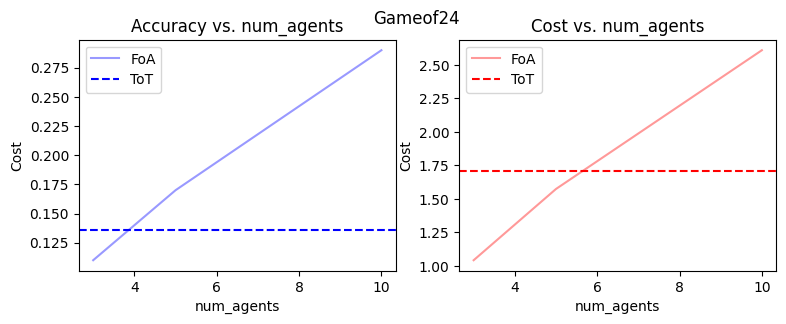

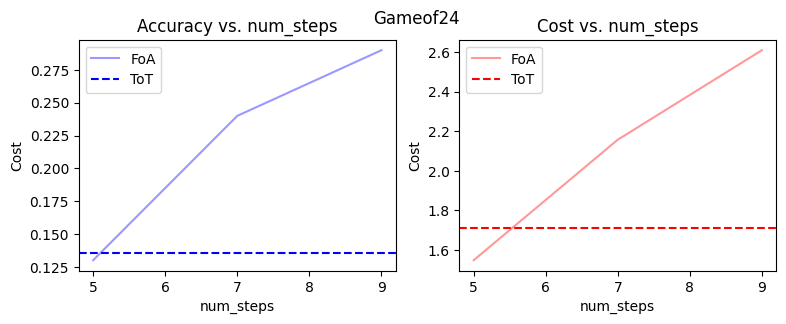

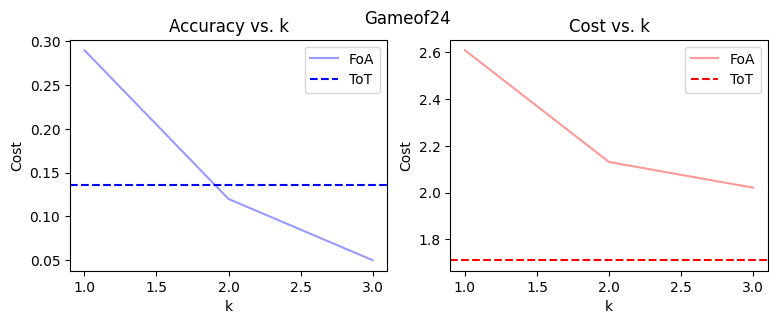

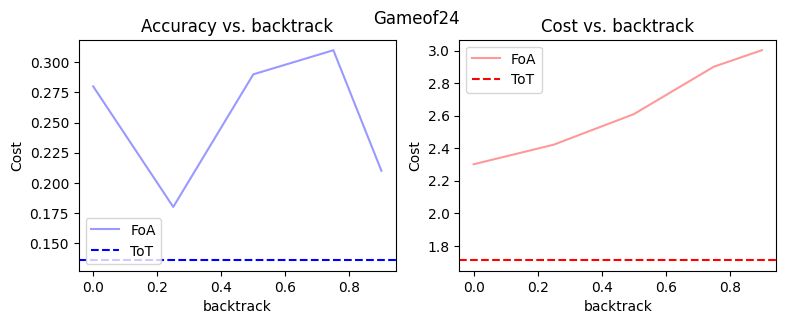

In [5]:
df = pd.DataFrame(data)
task="gameof24"

best_config = {"num_agents":10, "num_steps":9, "k":1, "backtrack":0.5}

# num_agents
variable = "num_agents"
temp = df[(df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
temp = temp.sort_values(variable, ascending=True)
xs = temp[variable].to_list()
y1 = temp["Accuracy"].to_list()
y2 = temp["Cost"].to_list()
plot_acc_cost(xs, y1, y2, variable, task)

# num_steps
variable="num_steps"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
temp = temp.sort_values(variable, ascending=True)
xs = temp[variable].to_list()
y1 = temp["Accuracy"].to_list()
y2 = temp["Cost"].to_list()
plot_acc_cost(xs, y1, y2, variable, task)

# k
variable = "k"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["backtrack"] == best_config["backtrack"])]
temp = temp.sort_values(variable, ascending=True)
xs = temp[variable].to_list()
y1 = temp["Accuracy"].to_list()
y2 = temp["Cost"].to_list()
plot_acc_cost(xs, y1, y2, variable, task)

# backtrack
variable = "backtrack"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"])]
temp = temp.sort_values(variable, ascending=True)
xs = temp[variable].to_list()
y1 = temp["Accuracy"].to_list()
y2 = temp["Cost"].to_list()
plot_acc_cost(xs, y1, y2, variable, task)

# Crosswords

In [6]:
#-----------------#
#---ToT Results---#
#-----------------#


def get_tot_results(file_path):

    with open(file_path) as f:
        results = json.load(f)

    cost = results.pop(-1)["cost"]
    best_steps = []
    for game in results:
        step_len = [len(step["actions"]) for step in game]
        if step_len == []:
            # Empty game -> No suggestions at root node
            best_steps.append({"total_step":0, "env_step":0, "actions":[], 'info': {'r_letter': 0, 'r_word': 0},})
            continue
        best_step_index = step_len.index(max(step_len))
        best_step = game[best_step_index]
        best_steps.append(best_step)
    
    r_letters = [game["info"]["r_letter"] for game in best_steps]
    r_words = [game["info"]["r_word"] for game in best_steps]
    r_game = [1 if game["info"]["r_word"]==1 else 0 for game in best_steps]

    rewards = {"r_letter": r_letters, "r_word": r_words, "r_game": r_game}
    return rewards, cost
    
    
folder = "arxiv/benchmarks/crosswords/ChatGPT/ToT/"
files = [folder + f for f in get_file_names(folder)]
rewards = []
costs = []

for file in files:
    rewards_, cost_ = get_tot_results(file)
    rewards.append(rewards_)
    costs.append(cost_)

rewards = np.array([r["r_letter"] for r in rewards]).flatten()
costs = np.array(costs)

tot = {}    
tot["Accuracy"] = bootstrap(rewards.reshape((1,-1)), np.mean).bootstrap_distribution.mean()
tot["CI_Low"], tot["CI_High"] = bootstrap(rewards.reshape((1,-1)), np.mean).confidence_interval
tot["Cost"] = bootstrap(costs.reshape((1,-1)), np.mean).bootstrap_distribution.mean()

print(f"Game of 24 ToT results")
for key, value in tot.items():
    print(f"\t{key}: {value:.3f}")


Game of 24 ToT results
	Accuracy: 0.333
	CI_Low: 0.275
	CI_High: 0.391
	Cost: 0.480


In [7]:
#-----------------#
#---FoA Results---#
#-----------------#

def get_foa_data(file, metric="r_letter"):
    with open(file, "r") as experiment_file:
        run = json.load(experiment_file)
    
    data = {}
    params = file.split("/")[-1].split("_")
    data["num_agents"] = int(params[1].split("agents")[0])
    data["num_steps"] = int(params[2].split("steps")[0])
    data["k"] = int(params[3].split("k")[0])
    data["backtrack"] = float(params[5].split("backtrack")[0])

    data["Cost"] = run.pop("Cost")['Total cost']["total_cost"]

    metrics = {}
    for puzzle_id, puzzle_results in run.items():
        initial_puzzle = puzzle_results.pop("puzzle", None)       # Not needed just want to pop
        verifications = puzzle_results.pop("Verifications", None) # Not needed just want to pop

        max_actions = 0
        metrics[puzzle_id] = {"r_letter": None, "r_word": None, "r_all": None}
        for agent_id, agent_results in puzzle_results.items():
            for step_id, step_results in agent_results.items():
                step_actions = len(step_results["Step"].split(" -> "))
                if step_actions > max_actions:
                    max_actions = step_actions
                    metrics[puzzle_id] = step_results["metrics"]
        assert max_actions > 0, f"No actions found for {puzzle_id}"

    r_letters = [metric["r_letter"] for metric in metrics.values()]
    r_words = [metric["r_word"] for metric in metrics.values()]
    r_alls = [metric["r_all"] for metric in metrics.values()]
    metrics = {"r_letter": r_letters, "r_word": r_words, "r_all": r_alls}
    data[metric] = metrics[metric]
    data["Accuracy"] = np.mean(metrics[metric])

    data.update(metrics)
    
    return data

folder = "logs_old/gridsearch1/crosswords/"
files = [folder + f for f in get_file_names(folder)]

data = [get_foa_data(file) for file in files]

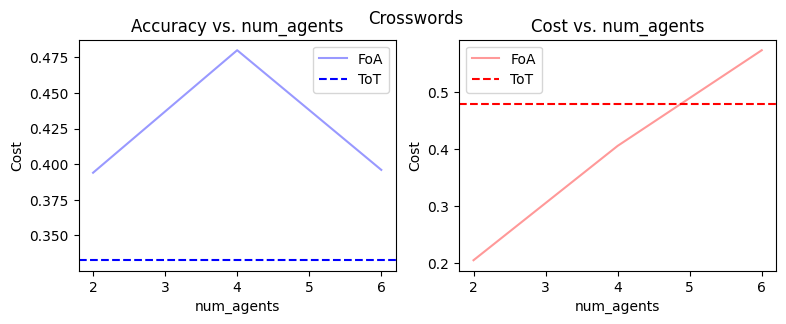

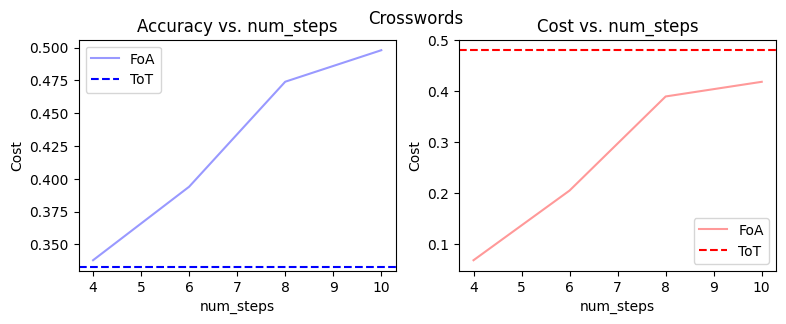

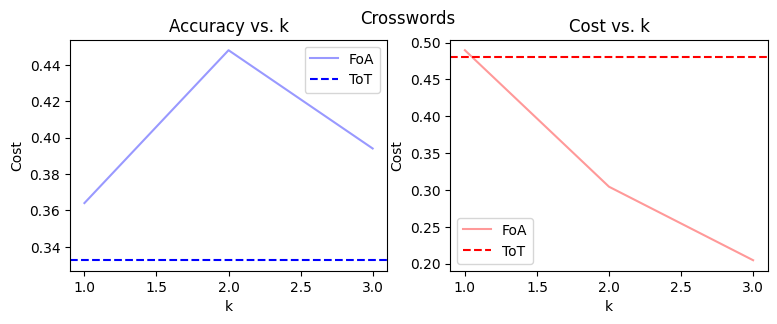

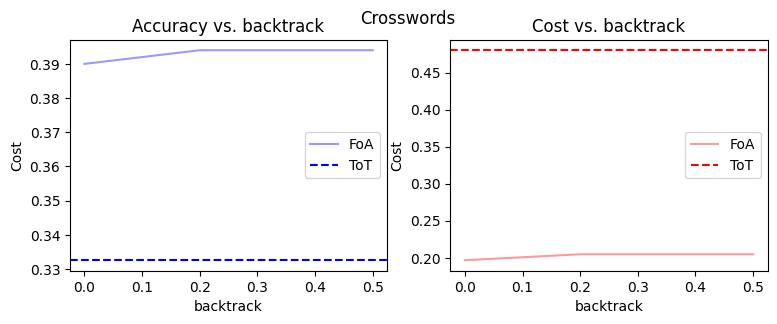

In [8]:
df = pd.DataFrame(data)
task = "crosswords"

best_config = {"num_agents":2, "num_steps":6, "k":3, "backtrack":0.5}

# num_agents
variable = "num_agents"
temp = df[(df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
temp = temp.sort_values(variable, ascending=True)
xs = temp[variable].to_list()
y1 = temp["Accuracy"].to_list()
y2 = temp["Cost"].to_list()
plot_acc_cost(xs, y1, y2, variable, task)

# num_steps
variable="num_steps"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["k"] == best_config["k"]) & (df["backtrack"] == best_config["backtrack"])]
temp = temp.sort_values(variable, ascending=True)
xs = temp[variable].to_list()
y1 = temp["Accuracy"].to_list()
y2 = temp["Cost"].to_list()
plot_acc_cost(xs, y1, y2, variable, task)

# k
variable = "k"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["backtrack"] == best_config["backtrack"])]
temp = temp.sort_values(variable, ascending=True)
xs = temp[variable].to_list()
y1 = temp["Accuracy"].to_list()
y2 = temp["Cost"].to_list()
plot_acc_cost(xs, y1, y2, variable, task)

# backtrack
variable = "backtrack"
temp = df[(df["num_agents"] == best_config["num_agents"]) & (df["num_steps"] == best_config["num_steps"]) & (df["k"] == best_config["k"])]
temp = temp.sort_values(variable, ascending=True)
xs = temp[variable].to_list()
y1 = temp["Accuracy"].to_list()
y2 = temp["Cost"].to_list()
plot_acc_cost(xs, y1, y2, variable, task)